In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pandas as pd
import xgboost as xgb

In [ ]:
# 데이터 로드
dataset = pd.read_csv('./diabetes.csv')

In [ ]:
# X와 Y로 데이터 분리
X = dataset.iloc[:,0:8] # 그냥 dataset으로 데이터분리가 안돼서, dataset.iloc으로 분리
y = dataset.iloc[:,8]   

In [ ]:
# 훈련 데이터와 검증 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 7) # X와 y로만 했을 때는 마지막 pred.proba할 때 에러생김


In [ ]:
# 학습 데이터로 모델 학습
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# 예측하기
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

In [ ]:
# 평가하기
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:%.2f%%'%(accuracy * 100))

Accuracy:81.17%


In [ ]:
# # 학습된 모델로 특정 환자에 대해 당뇨병을 진단하는 코드
# value = [1, 161, 72, 35, 0, 28.1, 0.527, 20]
# #value = {'Pregnancies' : 1,'GTT': 161,'Glucose' : 0.527, 'BloodPressure' : 72,'SkinThickness' : 35, 'Age' : 20, 'Insulin' : 0, 'BMI' : 28.1 }
# l = model.predict_proba(value)
# print('No diabetes: {:.2%}\n Yes diabetes:{:.2%}'.format(l[0][0], l[0][1]))

일반적인 학습 모델은 위의 과정을 통해 완성되고 그대로 사용된다. 

그러나 아직 정확도가 부족하다고 느낄 수 있다. 

하지만 우리는 지금 파라미터 튜닝만으로는 위 모델이 어떤 원리로 환자를 당뇨라고 진단하는지, 8가지 피처의 우선순위는 어떻게 구성되는지, 그리고 각 피처의 구치 변화에 따라 당뇨병 진단 가능성은 어떻게 변화하는지 등에 대한 질문에는 답할 수 없다. 

그렇기에 우리는 이 모델을 신뢰할만한 근거가 없다. 이때 XAI기법을 결합하면 더욱 현실적인 질문에 대답을 근간할 수 있다.

In [ ]:
# 시각화를 위한 파이썬 패키지 Graphviz 설치
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot
## 아래 있는것은 필수는 아닌데, 가끔 에러가 생길 때가 있어서, 그냥 같이 해줌. 
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz
import pygraphviz

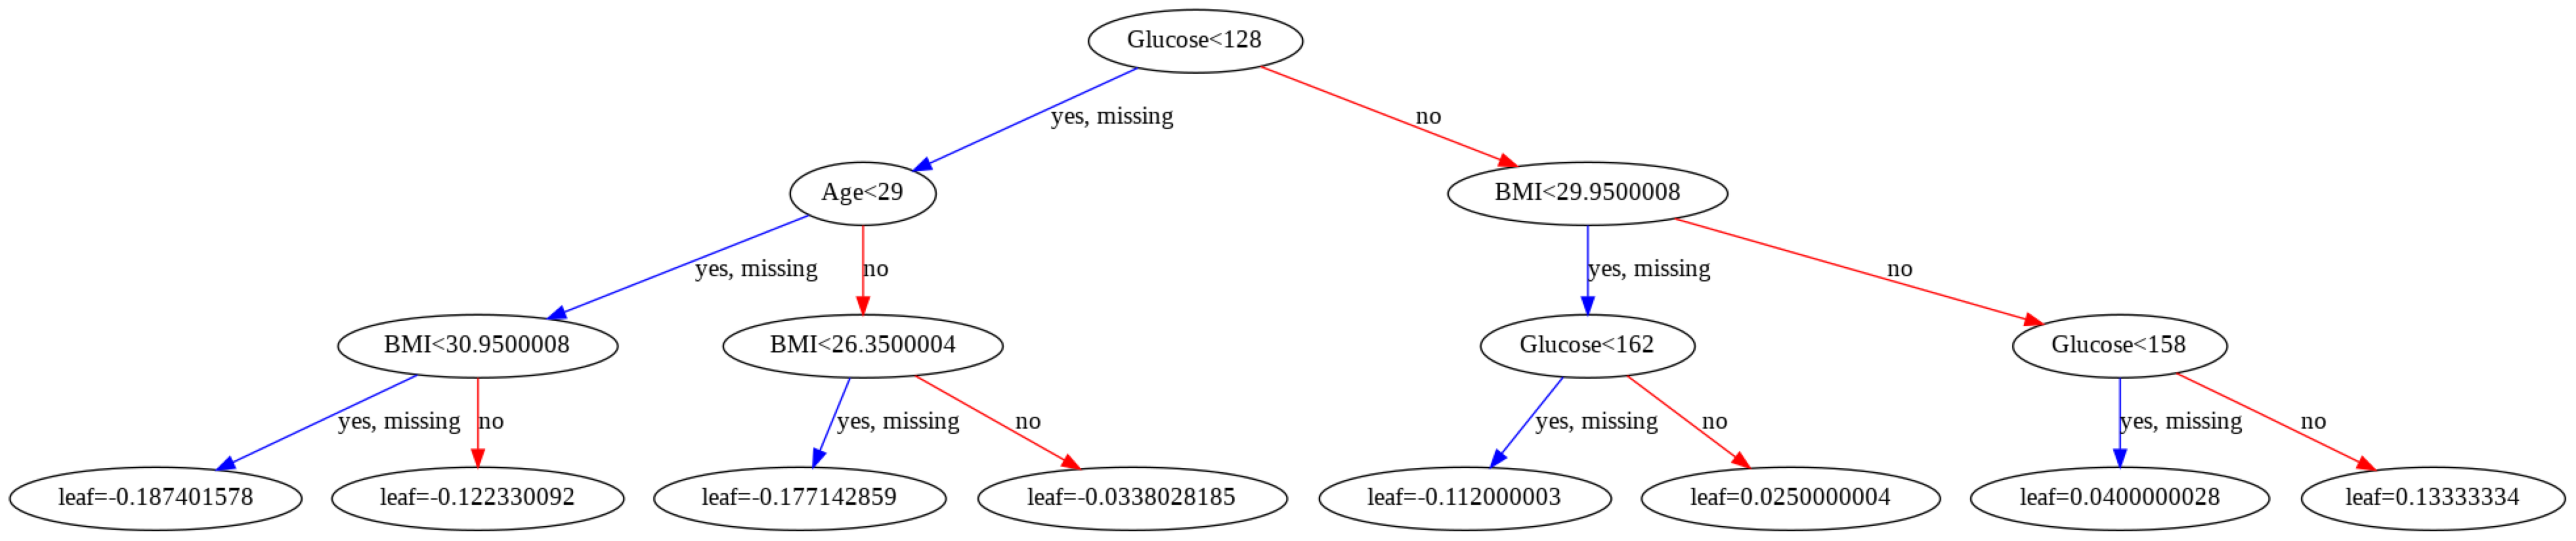

In [ ]:
# 의사 결정 트리 시각화
% matplotlib inline
from xgboost import plot_tree

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 100, 200
# 당뇨병 진단 학습 모델의 의사 결정 트리를 시각화하는 코드
plot_tree(model)
plt.show()

위의 그림에서 볼 수 있 듯,  GTT 태스트 결과가 128 미만인지를 묻고 있다. 이때 가지고 있는 데이터의 GTT가 128보다 크면 나이의 여부를 물어본다. 이런식으로 밑에 종단 노트까지 내려가 종단 노드의 값을 확인할 수 있다.

종단 노드의 값은 로지스틱 함수 확률값(logistic function probability score)으로, 0은 중립, 음수는 당뇨병 없음, 양수는 당뇨병 있음을 진단한다.
수식은 $p(x) = \frac{1}{1+e^{-leafvalue}}$
이며, leafvalue가 -0.11200003이면 확률은 0.472가 되고, 이진법 로지스틱 함수의 결과는 0.5가 넘으면 양성, 그렇지 않으면 음성으로 판단하기 때문에, 모델은 환자가 당뇨병을 앓고 있지 않다고 진단한다.

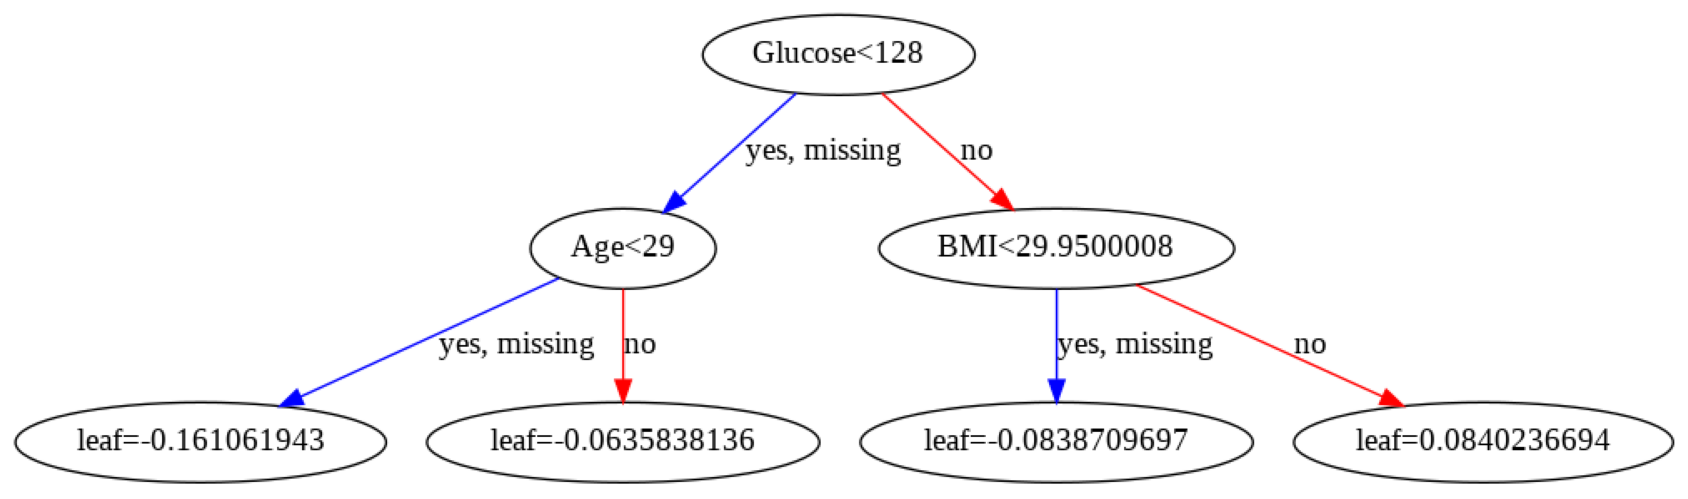

In [ ]:
# XGBClassifier의 max_depth의 옵션을 조절해 의사 결정 트리 가지치기
# 학습 데이터로 모델을 학습시키기
model = XGBClassifier(max_depth=2)

model.fit(x_train, y_train)
rcParams['figure.figsize'] = 30, 60
plot_tree(model)
plt.show()

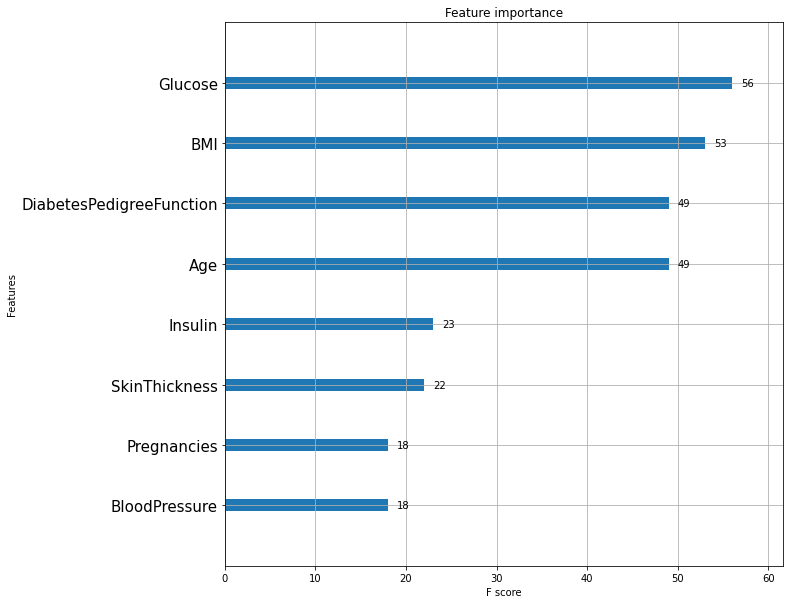

In [ ]:
# 당뇨병 진단 모델의 피처 중요도를 계산하고 시각화하기
from xgboost import plot_importance
rcParams['figure.figsize'] = 10,10
plot_importance(model)
plt.yticks(fontsize = 15)
plt.show()

위에 plot_importance는 학습된 모델을 가지고 각 피처를 분해해 중요도 행렬(importance matrix)을 계산함. 중요도 행렬은 의사 결정 트리와 유사하게 피처의 중요성을 줄 세우기하고 각 피처의 커버리지, 정보 이득 값(Gain)을 계산함. 그리고 plot_importance는 중요도 행렬의 결괏값을 F-measure 점수로 표현하고 정렬한다.

앞서 트리의 깊이가 3일 때, 최상단 노드의 분기점은 GTT 수치였다. 그리고 위의 그래프에서도 Glucose 피처가 당뇨병을 진단하는 데 가장 중요한 요소라고 들어났다.물론 피처 중요도의 순서가 무조건 의사 결정 트리의 순서를 결정하는 것은 아니지만, 의사 결정 트리는 노드의 선정과 분기 기준이 정보 이득이 큰 방향이고, 피처 중요도는 모델의 분류 에러가 큰 순서로 정렬되기 때문이다. 

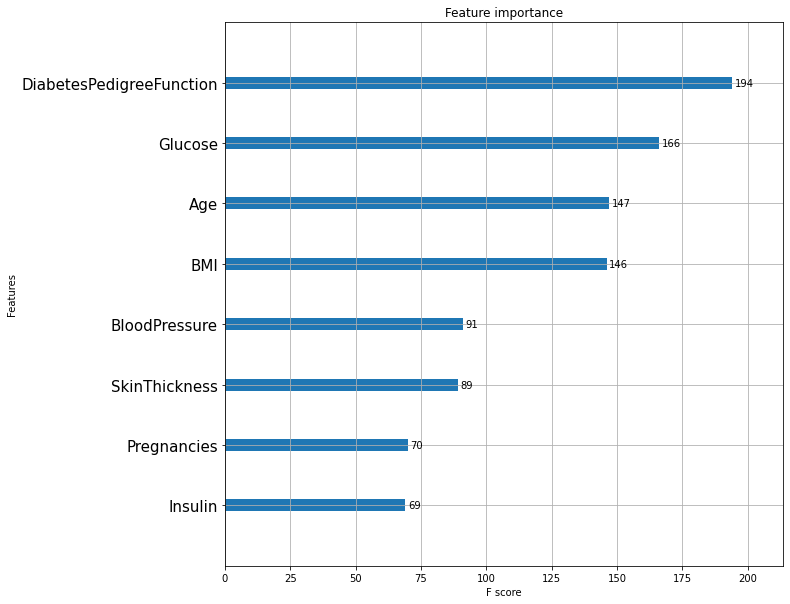

In [ ]:
# 트리 깊이가 4일 때 피처 중요도 그래프
model = XGBClassifier(max_depth=4)
rcParams['figure.figsize'] = 10,10
model.fit(x_train, y_train)
plot_importance(model)
plt.yticks(fontsize = 15)
plt.show()


위의 그림에서는 가지 깊이가 2일 때와 달리, 당뇨병 병력 함수(DiabetesPedigreeFunction)가  글루코오스 피처보다 높게 측정되었다.

# 부분 의존성 플롯
부분 의존성 플롯은 피처의 수치 변화에 따라 모델에 기여하는 정도가 어떻게 달라지는지 확인할 수 있는 XAI 기법입니다. 
피처도 학습데이터처럼, 만약 특정 데이터가 편향돼 있고, 그 데이터에 맞춰 결론이 왜곡돼 있다면 모델을 뜯어보지 않아도 어떤 편향으로 모델이 학습될지 파악할 수 있다. 부분 의존성 기법은 데이터를 분석합니다. 

In [ ]:
! pip install pdpbox

     |████████████████████████████████| 34.0MB 81kB/s 
     |████████████████████████████████| 13.1MB 234kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758227 sha256=30c2a57a8e35f1a4a13bf521ec4b3c6639242ff11f4c76011355bc99dce54fb1
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


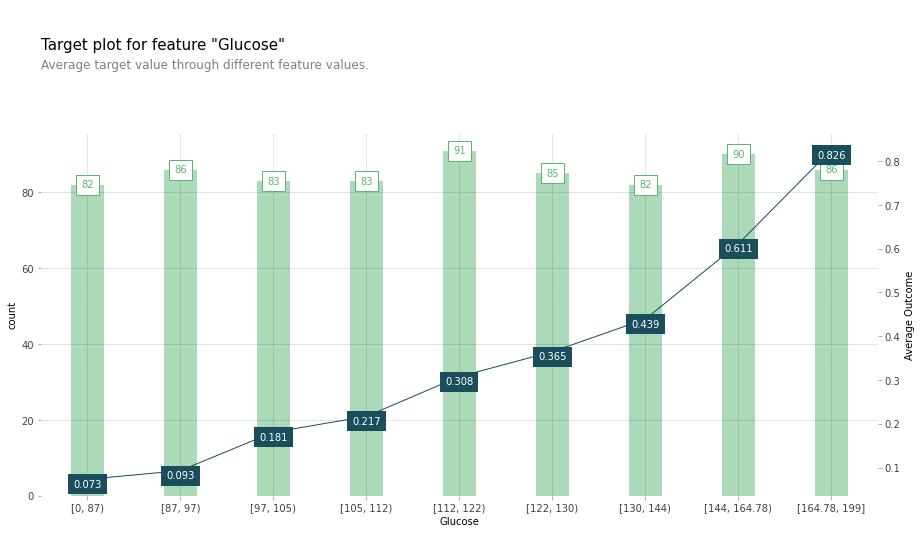

In [ ]:
# 부분 의존성 플롯 
from pdpbox import info_plots

pima_data = dataset
pima_features = dataset.columns[:8]
pima_target = dataset.columns[8]
fig, axes, summary_df = info_plots.target_plot(
    df = pima_data,
    feature = 'Glucose',
    feature_name = 'Glucose',
    target = pima_target
)

- 위의 그림처럼, X축은 GTT 수치, 왼쪽 Y 축은 각 수치 구간별 데이터 개수, 오른쪽 Y 축은 당뇨병 진단여부(>50%)다. 막대그래프는 왼쪽 Y축에 대응하고, 꺽은선 그래프는 오른쪽 Y축에 대응한다.
- 예를 들어, GTT가 84mg/dl인 경우, 데이터가 속한 그룹은 맨 왼쪽 첫 번째 막대그래프에 속하며, 데이터 수는 82개다. 또한 GTT가 84mg/dl인 환자에 대해 수치만 관찰했을 때 당뇨를 진단할 확률은 오른쪽 Y축에 대응하며, 확률은 평균 7.3%다. 반대로 GTT 수치가 181mg/dl인 환자는 가장 오른쪽 막대그래프 그룹에 속하며, 이때 모델이 환자를 당뇨병이라 진단할 확률은 평균 82.6%다.

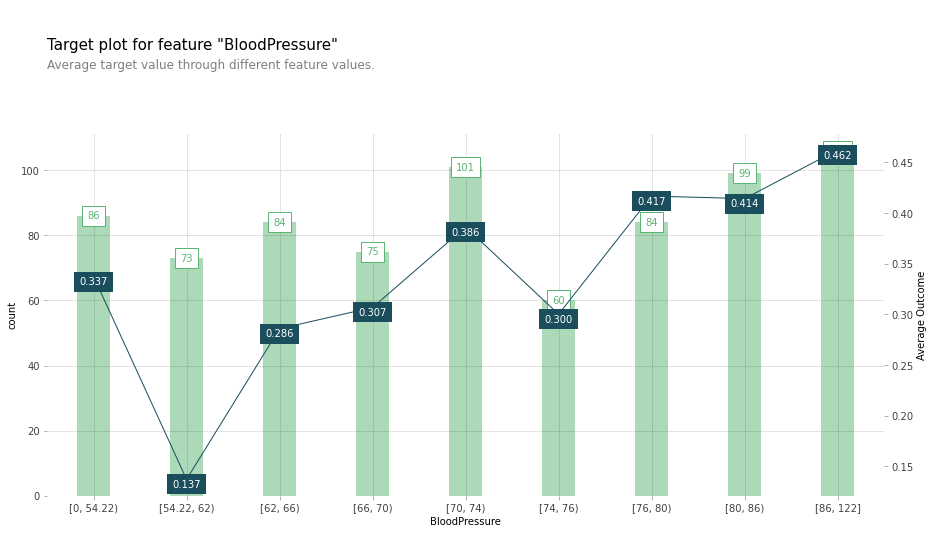

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df = pima_data,
    feature = 'BloodPressure',
    feature_name = 'BloodPressure',
    target = pima_target
)

- 고혈압의 진단 범위는 80-120mmHg이상일 때이다. 위 그림에서 확인할 수 있듯이, 정상기 혈압 범주에서 당뇨병 진단할 가능성은 30% 정도를 웃돈다. 그마저도 혈압이 가장 높은 그룹(가장 오른쪽 막대그래프)에서 46.2%로 우상향한다. 그렇지만 혈압이 122mmHG인 환자에 대해서도 당뇨병 진단 가능성이 50%를 넘지 않는다. 따라서 혈압 피처만으로 당뇨병을 진단하는 것은 섣부르다고 결론지을 수 있다. 이 결과는 앞서 의사 결정 트리 시각화의 결론과 일치한다.

In [ ]:
# pandas 의 데이터프레임 포맷으로 저장.
summary_df

,x,display_column,value_lower,value_upper,count,Outcome
0,0,"[0, 54.22)",0.000000,54.222222,86,0.337209
1,1,"[54.22, 62)",54.222222,62.000000,73,0.136986
2,2,"[62, 66)",62.000000,66.000000,84,0.285714
3,3,"[66, 70)",66.000000,70.000000,75,0.306667
4,4,"[70, 74)",70.000000,74.000000,101,0.386139
5,5,"[74, 76)",74.000000,76.000000,60,0.300000
6,6,"[76, 80)",76.000000,80.000000,84,0.416667
7,7,"[80, 86)",80.000000,86.000000,99,0.414141
8,8,"[86, 122]",86.000000,122.000000,106,0.462264


# 예측 분포 기보 플롯
- 데이터와 실제 모델을 결합해 두 결과가 일치하는지 확인해보자

/usr/local/lib/python3.7/dist-packages/pdpbox/info_plots.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['actual_prediction'] = prediction[:, 1]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


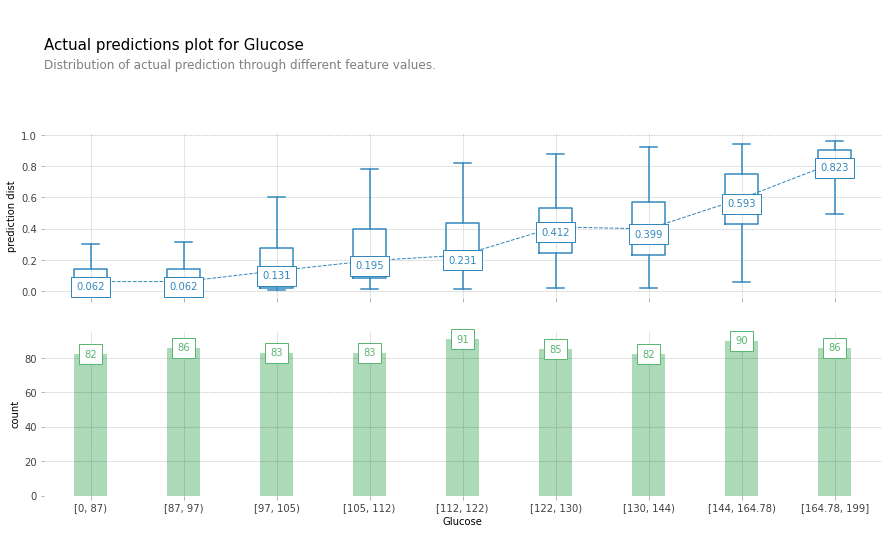

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
    model = model,
    X = pima_data[pima_features],
    feature = 'Glucose',
    feature_name = 'Glucose',
    predict_kwds = {}
)

- 위 그림은 예측 분포셀과 데이터 누적 셀로 나뉘어 있다. 예측 분포 셀에서 "모델"이 특정 수치를 보이는 환자들에 대해 당뇨병이 있으리라 추정하는 캔들스틱 차트.
- 그럼 이제 상단차트의 특정 환자(GTT 테스트 결과가 0-87mg/dl)의 결과를 해석해 보자.
    - 이 수치를 보이는 환자들은 평균 5.2%의 확률로 당뇨병을 앓고 있다고 추정된다. 이때 캔들 스틱 차드의 최대치는 0.3 보다 작다. 따라서  모델이 해당 구간에서 당뇨가 있으리라 추정하는 수치는 최대 30%를 넘지 않게 학습될 것이다.